# 자연어처리 (Natural Language)
## 실습06 - RNN 으로 MNIST 분류하기
#### 201810793 이연우

## 0.1 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

## 0.2 하이퍼파라미터 셋팅

In [2]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size =128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2 # 몇회 학습할 것인지
learning_rate = 0.01

In [3]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. MNIST train, test dataset 가져오기

In [4]:
# MNIST dataset
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST("", train = True, transform = transforms.ToTensor(),
                         target_transform = None, download = True)# Train용으로 쓰겠다.
mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(),
                        target_transform = None, download = True) #Test용으로 쓰지 않겠다.

## 2. 대략적인 데이터 형태

mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


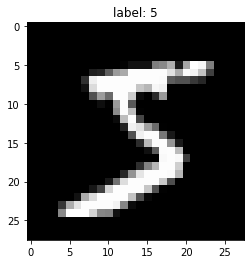

In [5]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0)  # 0번째 데이터
print("image data 형태: ", image.size())
print("label: ", label)

# 그리기
img = image.numpy()  # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

## 3. 데이터 로드함수
학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset = mnist_train, # mnist_train을 트레인 시키자
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True) # batch_size 만큼 나눌 때 나머지는 버려라

test_loader = torch.utils.data.DataLoader(dataset = mnist_test,
                                          batch_size = batch_size,
                                          shuffle = False, # test에서는 shuffle하지 않음
                                          drop_last = True) # batch_size 만큼 나눌 때 나머지는 버려라

### 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기:  100


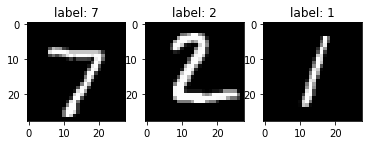

[1]
한 번에 로드되는 데이터 크기:  100


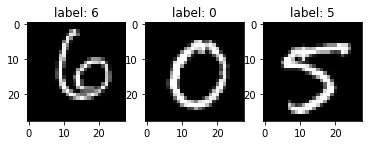

[2]
한 번에 로드되는 데이터 크기:  100


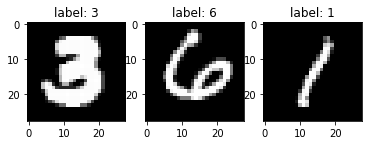

[3]
한 번에 로드되는 데이터 크기:  100


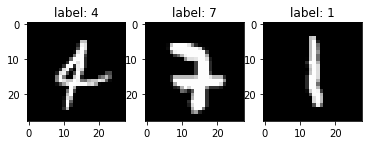

[4]
한 번에 로드되는 데이터 크기:  100


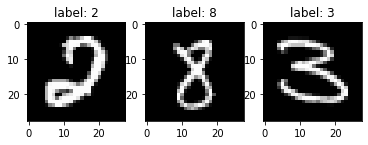

[5]
한 번에 로드되는 데이터 크기:  100


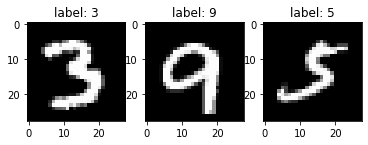

In [7]:
n = 3  # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader):  # batch_size만큼
    if i>5: 
        break

    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기: ", len(imgs))

    # 그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy로 변환 (1, 28, 28)
        img = img.reshape((img.shape[1], img.shape[2]))  # (1,28,28) -> (28,28)
        
        plt.subplot(1, n, j+1)  # (1,3)형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap = 'gray')
        plt.title("label: %d" %labels[j])
    plt.show()

## 4. 모델선언
- Multi-layered RNN 
- LSTM

In [8]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # 구조 선언
        super(RNN, self).__init__()
        self.hidden_size = hidden_size # 128
        self.num_layers = num_layers # 2
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes) 
    def forward(self, x):
        # -------
        # input tensor: (batch_size, seq_length, input_size)
        # x: (100, 28, 28)
        # print('x: ', x.shape)

        # -------
        # hidden state tensor: (# of layers, batch_size, hidden_size)
        # h: (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        # -------
        # Forward propagate LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        # out: (100, 28, 128)
        # print('out: ', out.shape)
        
        out, _ = self.lstm(x, (h0, c0))

        # -------
        # 28번째 output layer: (bs, hidden_size)
        # out[:, -1, :]: (100, 128)
        # print('out[-1]: ', out[:, -1, :].shape)

        # -------
        out = self.fc(out[:, -1, :]) # batch size와 hidden size는 다 가져오고, 마지막 부분만

        # y^ : (batch_size, num_classes)
        # y_pred: (100, 10)
        # print('out: ', out.shape)
        return out

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [10]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader):  # batch_size 만큼
        # x: (batch_size, 1, seq_length, input_size) 
        #-> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)  # Variable(labels)
        # label = Variable(labels).cuda()

        # Forward prop.
        output = imodel(img)  # (batch_size, num_classes)
        _, output_index = torch.max(output, 1)  # (batch_size, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()
        
    # print("Accuracy of Test Data: {}".format(100*correct/total))
    return (100*correct/total).numpy()  # tensor -> numpy

In [11]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))
# 전혀 학습이 안됨.. 10%

Accuracy of Test Data: 11.35


## 5. loss, optimizer

In [12]:
# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## 6. 학습

In [13]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i , [imgs, labels] in enumerate(train_loader):
        # x : (batch_size, 1, seq_length, input_size)
        # -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        # y: (batch_size, num_classes)
        label = labels.to(device)
        
        # Forward prop
        outputs = model(img)
        loss = loss_func(outputs, label)
        
        # 학습하는 부분
        # Backward prop. & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i +1) % 100 == 0 :
            print('Epoch [{}/{}], Step [{},{}], Loss : {:.4f}, Accr: {:.2f}' 
                  .format(epoch+1, num_epochs, i+1, total_step,loss.item()
                          ,ComputeAccr(test_loader, model)))

Epoch [1/2], Step [100,600], Loss : 0.6460, Accr: 85.47
Epoch [1/2], Step [200,600], Loss : 0.1369, Accr: 92.74
Epoch [1/2], Step [300,600], Loss : 0.2855, Accr: 94.43
Epoch [1/2], Step [400,600], Loss : 0.2397, Accr: 95.66
Epoch [1/2], Step [500,600], Loss : 0.2154, Accr: 96.69
Epoch [1/2], Step [600,600], Loss : 0.1150, Accr: 96.72
Epoch [2/2], Step [100,600], Loss : 0.0896, Accr: 97.60
Epoch [2/2], Step [200,600], Loss : 0.0603, Accr: 96.77
Epoch [2/2], Step [300,600], Loss : 0.0587, Accr: 96.90
Epoch [2/2], Step [400,600], Loss : 0.0202, Accr: 97.38
Epoch [2/2], Step [500,600], Loss : 0.0144, Accr: 97.41
Epoch [2/2], Step [600,600], Loss : 0.0166, Accr: 97.91


## 7. 테스트

In [14]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.91


## 8. 학습된 파라미터 저장 

In [15]:
netname = './nets/rnn_weight.pkl'
torch.save(model, netname,)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.91
